In [1]:
# --------------------------------------------------------------------machine learning--------------------------------------------------------------------
%matplotlib inline
!pip install mne &> /dev/null

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
import os
import numpy as np
import mne
import matplotlib.pyplot as plt
import math
from scipy.io import loadmat

In [4]:
mne.set_log_level(False)

In [5]:
def load_ds(pt, f):       # For BCIC Dataset
  fp = os.path.join(pt, f)
  print("File path: {}".format(fp))
  if fp.endswith('gdf'):
    raw_data = mne.io.read_raw_gdf(fp)
  else:
    raw_data = None
  return raw_data

In [6]:
sbj_n = 4 #@param {type:"integer"}
sbj_path = 'Subject ' + str(sbj_n)

In [7]:
base_path = '/content/drive/MyDrive/EEG data'
subj_folder = os.path.join(base_path, sbj_path)
l = [file for file in os.listdir(subj_folder) if file.endswith('gdf')]

In [8]:
print(l)

['record-[2024.03.10]_S9_1.gdf', 'record-[2024.03.10]_S7_1.gdf', 'record-[2024.03.10]_S8_2.gdf', 'record-[2024.03.10]_S10_2.gdf']


In [9]:
picked = l[0]
print(picked)

record-[2024.03.10]_S9_1.gdf


In [10]:
ch_list = ['Fp1', 'Fp2', 'AF3', 'AF4', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FT7', 'FC3', 'FCz','FC4', 'FT8', 'T7', 'C3', 'Cz', 'C4', 'T8', 'TP7', 'CP3', 'CPz', 'CP4', 'TP8', 'P7', 'P3', 'Pz', 'P4', 'P8', 'O1', 'Oz', 'O2']

In [11]:
x = load_ds(subj_folder, picked)
print(x.annotations)

File path: /content/drive/MyDrive/EEG data/Subject 4/record-[2024.03.10]_S9_1.gdf
<Annotations | 67 segments: 1010 (1), 33024 (17), 769 (8), 770 (8), 800 (33)>


In [12]:
channel_mapping = {old_name: new_name for old_name, new_name in zip(x.ch_names, ch_list)}
x.rename_channels(channel_mapping)

Measurement date,Unknown
Experimenter,Unknown
Participant,0x00000000
Digitized points,Not available
Good channels,32 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,500.00 Hz
Highpass,0.00 Hz
Lowpass,250.00 Hz


In [ ]:
x.compute_psd(fmax=50).plot(picks="data", exclude="bads", amplitude=False)

In [ ]:
# Create a standard montage (e.g., 10-20 system)
montage = mne.channels.make_standard_montage('standard_1020')

# Plot the montage to visualize the electrode positions
fig, ax = plt.subplots(figsize=(6, 6))
_ = montage.plot(show_names=True, axes=ax)
_ = x.set_montage(montage)

In [15]:
events_from_annot, event_dict = mne.events_from_annotations(x)
# print(events_from_annot)
print(event_dict)

{'1010': 1, '33024': 2, '769': 3, '770': 4, '800': 5}


In [16]:
l_ev = event_dict['769']
r_ev = event_dict['770']
x_ev = event_dict['33024']
end_trial = event_dict['800']
needed_event = [l_ev, r_ev, x_ev, end_trial]
print(events_from_annot.shape)

(67, 3)


In [17]:
re = events_from_annot[::-1, 2].tolist()  # reverse
last_id = re.index(end_trial)
# delete the end_trail event
if last_id > 0:
  events_annot = events_from_annot[:-last_id]
else:
  events_annot = events_from_annot[:]

In [18]:
# Extract rows from events_annot that contain specified event values.
mask = np.isin(events_annot[:, 2], needed_event)
filtered_events = events_annot[mask]
# print(filtered_events)

In [19]:
# Time difference between
a = np.diff(filtered_events[:, 0])/x.info['sfreq']
# Durations
dur = round(np.mean(a[::2]),2)
print(dur)

6.21


In [20]:
unique, counts = np.unique(filtered_events[:,2], return_counts=True)
print(unique)
print(counts)

[2 3 4 5]
[17  8  8 33]


In [21]:
st = 0

In [22]:
epoch_l = mne.Epochs(x, events_from_annot, event_id=l_ev, tmin=st, tmax=st+dur, baseline=None, preload=True)
epoch_r = mne.Epochs(x, events_from_annot, event_id=r_ev, tmin=st, tmax=st+dur, baseline=None, preload=True)
epoch_x = mne.Epochs(x, events_from_annot, event_id=x_ev, tmin=st, tmax=st+dur, baseline=None, preload=True)

In [23]:
print(epoch_l)
print(epoch_r)
print(epoch_x)

<Epochs |  8 events (all good), 0 – 6.21 s, baseline off, ~6.1 MB, data loaded,
 '3': 8>
<Epochs |  8 events (all good), 0 – 6.21 s, baseline off, ~6.1 MB, data loaded,
 '4': 8>
<Epochs |  16 events (all good), 0 – 6.21 s, baseline off, ~12.2 MB, data loaded,
 '2': 16>


In [24]:
#filter with specific bandpass

# epoch_l.filter(l_freq=1, h_freq=40)
# epoch_r.filter(l_freq=1, h_freq=40)
# epoch_x.filter(l_freq=1, h_freq=40)

# alpha
epoch_l.filter(l_freq=8, h_freq=12)
epoch_r.filter(l_freq=8, h_freq=12)
epoch_x.filter(l_freq=8, h_freq=12)

# beta
# epoch_l.filter(l_freq=13, h_freq=30)
# epoch_r.filter(l_freq=13, h_freq=30)
# epoch_x.filter(l_freq=13, h_freq=30)

Number of events,16
Events,2: 16
Time range,0.000 – 6.210 s
Baseline,off


In [25]:
ep_n = 0 #@param {type:"integer"}

In [26]:
sub_dur = 2
stride = 0.25
sf = x.info['sfreq']

In [27]:
def sub_epochs(epochs):
  smaller_epochs = []
  for epoch in epochs:
    data = epoch[np.newaxis,:,:]
    # Calculate the number of smaller epochs that can be created
    n_epochs = (data.shape[2] - (sub_dur * sf)) // (stride * sf) + 1
    for i in range(int(n_epochs)):
        start_sample = int(i * (stride * sf))
        end_sample = start_sample + int(sub_dur * sf)
        smaller_epoch_data = data[:, :, start_sample:end_sample]

        # Create a new Epoch object with the smaller epoch data
        smaller_epoch = mne.EpochsArray(smaller_epoch_data, info=epochs.info)
        smaller_epochs.append(smaller_epoch)

  # Combine all the smaller epochs into a single Epochs object
  smaller_epochs = mne.epochs.concatenate_epochs(smaller_epochs)
  return smaller_epochs
def create_label(size, lbl):
  return np.full(size, lbl)

In [28]:
mini_ep_l = sub_epochs(epoch_l)
mini_ep_r = sub_epochs(epoch_r)
mini_ep_x = sub_epochs(epoch_x)

In [29]:
print(len(mini_ep_l)/8)
print(len(mini_ep_r)/8)
print(len(mini_ep_x)/8)
# 1 Epoch --> 17 sub-epoch --> Use index | 2[Early] ---- 8 [Mid] ---- 15[Late] |

17.0
17.0
34.0


In [30]:
ep_l = mini_ep_l.get_data()
ep_r = mini_ep_r.get_data()
ep_x = mini_ep_x.get_data()

<ipython-input-30-744d8960eed5>:1: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  ep_l = mini_ep_l.get_data()
<ipython-input-30-744d8960eed5>:2: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  ep_r = mini_ep_r.get_data()
<ipython-input-30-744d8960eed5>:3: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  ep_x = mini_ep_x.get_data()


In [31]:
lbl_l = create_label(ep_l.shape[0], 1)
lbl_r = create_label(ep_r.shape[0], 2)
lbl_x = create_label(ep_x.shape[0], 0)

In [32]:
print(ep_l.shape)
print(lbl_l.shape)

(136, 32, 1000)
(136,)


In [33]:
epoch_data = np.concatenate((ep_l, ep_r, ep_x),axis=0)
label_data = np.concatenate((lbl_l, lbl_r, lbl_x),axis=0)
# print(epoch_data)
print(len(label_data))

544


In [ ]:
print(label_data)

###LDA

In [36]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(epoch_data, label_data, test_size=0.2, random_state=42)
X_train_flat = X_train.reshape(X_train.shape[0], -1)


lda = LinearDiscriminantAnalysis()
clf = Pipeline([("LDA", lda)])
clf.fit(X_train_flat, y_train)
accuracy = clf.score(X_test.reshape(X_test.shape[0], -1), y_test)
print("Classification accuracy: %f" % np.mean(accuracy))


Classification accuracy: 0.394495


###SVM

In [38]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(epoch_data, label_data, test_size=0.2, random_state=42)
X_train_flat = X_train.reshape(X_train.shape[0], -1)

svc = SVC(kernel='rbf', probability=True)
clf = Pipeline([("SVM", svc)])
clf.fit(X_train_flat, y_train)
accuracy = clf.score(X_test.reshape(X_test.shape[0], -1), y_test)
print("Classification accuracy: %f" % np.mean(accuracy))


Classification accuracy: 0.477064


###CSP + LDA

In [42]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit, cross_val_score
from sklearn.pipeline import Pipeline
from mne.decoding import CSP

####Without Cross-Valid

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(epoch_data, label_data, test_size=0.2, random_state=42)
lda = LinearDiscriminantAnalysis()
csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)
clf = Pipeline([("CSP", csp), ("LDA", lda)])
clf.fit(X_train, y_train)
accuracy = clf.score(X_test, y_test)
print("Classification accuracy: %f" % np.mean(accuracy))

####Cross-Valid

In [46]:
X_train, X_test, y_train, y_test = train_test_split(epoch_data, label_data, test_size=0.2, random_state=42)
cv = ShuffleSplit(5, test_size=0.2, random_state=42)
cv_split = cv.split(X_train, y_train)

In [47]:
lda = LinearDiscriminantAnalysis()
csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)

In [48]:
clf = Pipeline([("CSP", csp), ("LDA", lda)])
scores = cross_val_score(clf, X_train, y_train, cv=cv, n_jobs=None)

In [49]:
class_balance = np.mean(y_train == y_train[0])
class_balance = max(class_balance, 1.0 - class_balance)
print(
    "Classification accuracy: %f / Chance level: %f" % (np.mean(scores), class_balance)
)

Classification accuracy: 0.721839 / Chance level: 0.737931


###CSP + SVM

In [44]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
cv = ShuffleSplit(5, test_size=0.2, random_state=42)
cv_split = cv.split(X_train, y_train)
svc = SVC(kernel='rbf', probability=True)
csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)
scaler = StandardScaler()
clf = Pipeline([("CSP", csp), ("SVM", svc)])
scores = cross_val_score(clf, X_train, y_train, cv=cv, n_jobs=None)

# Printing the results
class_balance = np.mean(y_train == y_train[0])
class_balance = max(class_balance, 1.0 - class_balance)
print("Classification accuracies: " ,scores)
print("Classification accuracy: %f / Chance level: %f" % (np.mean(scores), class_balance))

Classification accuracies:  [0.72413793 0.73563218 0.77011494 0.75862069 0.75862069]
Classification accuracy: 0.749425 / Chance level: 0.737931


#Confusion matrix

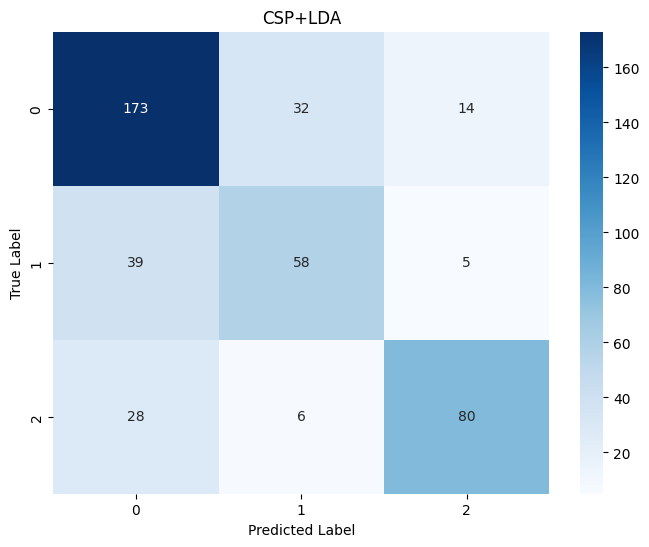

In [50]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_predict

cv = 5  # 這裡的 5 可以根據需要調整
X_train, X_test, y_train, y_test = train_test_split(epoch_data, label_data, test_size=0.2, random_state=42)
# X_train_flat = X_train.reshape(X_train.shape[0], -1)
# # 使用 cross_val_predict 進行交叉驗證預測
# clf = Pipeline([("CSP", csp), ("SVM", svc)])
clf = Pipeline([("CSP", csp), ("LDA", lda)])
# clf = Pipeline([("SVM", svc)])
# clf = Pipeline([("LDA", lda)])
y_pred = cross_val_predict(clf, X_train, y_train, cv=cv)

# 計算混淆矩陣
cm = confusion_matrix(y_train, y_pred)

# 可視化混淆矩陣
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1', '2'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('CSP+LDA')
plt.show()


In [ ]:
# 訓練模型
clf.fit(X_train, y_train)

# 預測測試集
y_pred = clf.predict(X_test)

# 計算混淆矩陣
cm = confusion_matrix(y_test, y_pred)

# 可視化混淆矩陣
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['foot', 'left_hand', 'right_hand'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

#Unsupervise Test

###PCA

In [173]:
from sklearn.decomposition import PCA, FastICA
from mne.decoding import UnsupervisedSpatialFilter
from sklearn.cluster import KMeans
pca = UnsupervisedSpatialFilter(PCA(5), average=False)
pca_data = pca.fit_transform(epoch_data)
print(pca_data.shape)
print(epoch_data.shape)

(544, 5, 1000)
(544, 32, 1000)


####K-Means

In [ ]:
from sklearn.cluster import KMeans
# 將PCA處理後的數據展平為2D
pca_data_2d = pca_data.reshape(pca_data.shape[0], -1)

# 初始化 K-Means 分群器，假設你希望分成 3 個群集
kmeans = KMeans(n_clusters=3, random_state=42)

# 對資料進行 K-Means 聚類
cluster_labels = kmeans.fit_predict(pca_data_2d)

####DBSCAN

In [ ]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.5, min_samples=10)
# 對資料進行 DBSCAN 聚類
cluster_labels = dbscan.fit_predict(pca_data_2d)
print(cluster_labels)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Visualize the K-Means clustering results in 3D space
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot points with different colors based on cluster labels
for i in range(3):
    ax.scatter(pca_data_2d[cluster_labels == i, 0],
               pca_data_2d[cluster_labels == i, 1],
               pca_data_2d[cluster_labels == i, 2],
               label=f'Cluster {i}')

# Add labels and title
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('DBSCAN Clustering in 3D Space')

# Add legend
ax.legend()

# Show the plot
plt.show()

###ICA

In [152]:
ica = UnsupervisedSpatialFilter(FastICA(5, whiten="unit-variance"), average=False)
ica_data = ica.fit_transform(epoch_data)
print(ica_data.shape)

(544, 5, 1000)


####K-Means

In [153]:
# 初始化 K-Means 分群器，假設你希望分成 3 個群集
kmeans = KMeans(n_clusters=3, random_state=42)
ica_data_2d = ica_data.reshape(ica_data.shape[0], -1)
cluster_labels = kmeans.fit_predict(ica_data_2d)
# print(cluster_labels)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


####DBSCAN

In [ ]:
ica_data_2d = ica_data.reshape(ica_data.shape[0], -1)
dbscan = DBSCAN(eps=0.2, min_samples=8)
# 對資料進行 DBSCAN 聚類
cluster_labels = dbscan.fit_predict(ica_data_2d)
print(cluster_labels)

In [ ]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
for i in range(3):
    ax.scatter(ica_data_2d[cluster_labels == i, 0],
               ica_data_2d[cluster_labels == i, 1],
               ica_data_2d[cluster_labels == i, 2],
               label=f'Cluster {i}')

# 添加標籤和標題
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('DBSCAN Clustering in 3D Space')

# 添加圖例
ax.legend()

# ax.view_init(elev=0, azim=60)

# 顯示圖形
plt.show()

In [171]:
from sklearn.metrics import adjusted_rand_score, mutual_info_score, fowlkes_mallows_score

# Assuming ground_truth_labels are the ground truth labels
# Assuming cluster_labels are the labels predicted by K-Means

# Adjusted Rand Index (ARI)
ari = adjusted_rand_score(label_data, cluster_labels)
print("Adjusted Rand Index (ARI):", ari)

# Mutual Information (MI)
mi = mutual_info_score(label_data, cluster_labels)
print("Mutual Information (MI):", mi)

# Fowlkes-Mallows Index (FMI)
fmi = fowlkes_mallows_score(label_data, cluster_labels)
print("Fowlkes-Mallows Index (FMI):", fmi)


Adjusted Rand Index (ARI): 0.0
Mutual Information (MI): 0.0
Fowlkes-Mallows Index (FMI): 0.6114319153500704


In [ ]:
# --------------------------------------------------------------------machine learning--------------------------------------------------------------------